# Practical Tuesday Afternoon (Part 2): Vision RAG

This notebook aims to give a quick overview of Vision RAG techniques on lower end GPUs. The goal is NOT to reinvent the wheel, but rather give an overview of several current libs and good practices. Lots of concepts are in there - this notebook does not aim to explain them. This is what the TAs are for, and Google can help too !



It touches up on several key concepts:

1.  Instruction Fine-tuning a SLM (Part 1)
  *  Check out `Practical Tuesday Afternoon (Part 1)`

2. Retrieval Augmented Generation with Vision Language Models (Part 2)
  * Vision Language Models
  * ColPali
  * RAG
  * API Calls

<a target="_blank" href="https://colab.research.google.com/github/https://colab.research.google.com/drive/1lQh6VVTDwHecgtZjVa6Ag4Uj6Gm2S8rX?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Context

To improve the query answering capabilities of LLMs, it is often best to first search for information online or in external document sets (PDFs), before letting a LLM synthetize a grounded response (RAG). In practice, these retrieval pipelines for PDF documents have a huge impact on performance but are non-trivial...

* Run Optical Character Recognition (OCR) on scanned PDFs
* Run Document Layout Detection models to segment pages into paragraphs, figures, titles
* Reconstruct the structure and the reading order of the page
* Optionally, use resource intensive specialized models to caption figures, images and tables in natural language
* Use a chunking strategy to split or merge text passages in a coherent way
* Use a strong neural embedding model (BGE M3) to map text chunks to a semantically meaningful vector space
* Store the vector index to be used for future retrieval

Although tools exist to facilitate this pipeline (Unstructured, Surya), the whole indexing process can be slow, tends to propagate errors, and struggles to take into account the more visual elements of a page (tables, figures, images but also fonts, etc..).

**Our concept ? Just embed the page image directly !**


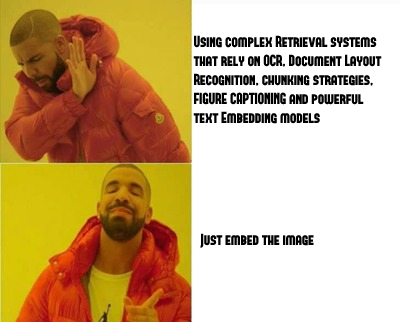

In practice, it’s not as easy as we just made it sound ! Our method, ColPali is enabled by the latest advances in Vision Language Models, notably the PaliGemma model from the Google Zürich team, and leverages multi-vector retrieval through late interaction mechanisms as proposed in ColBERT by Omar Khattab.

## An overview of VLMs

Vision Language Models (VLMs) are LLMs to which we can add image inputs (as if it were text).
Check out a quick overview here: https://huggingface.co/blog/vlms

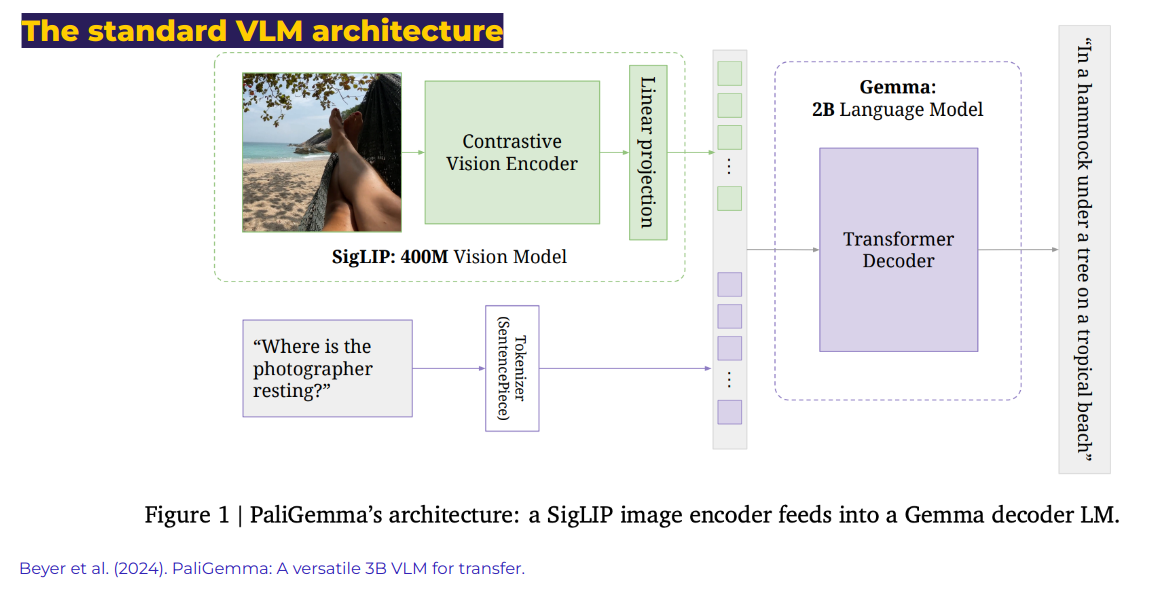

Turns out you can use these models to create strong document embeddings.
If that interests you, check out: https://huggingface.co/blog/manu/colpali
The following diagram illustrates the process quite well ! *(@helloiamleonie)*

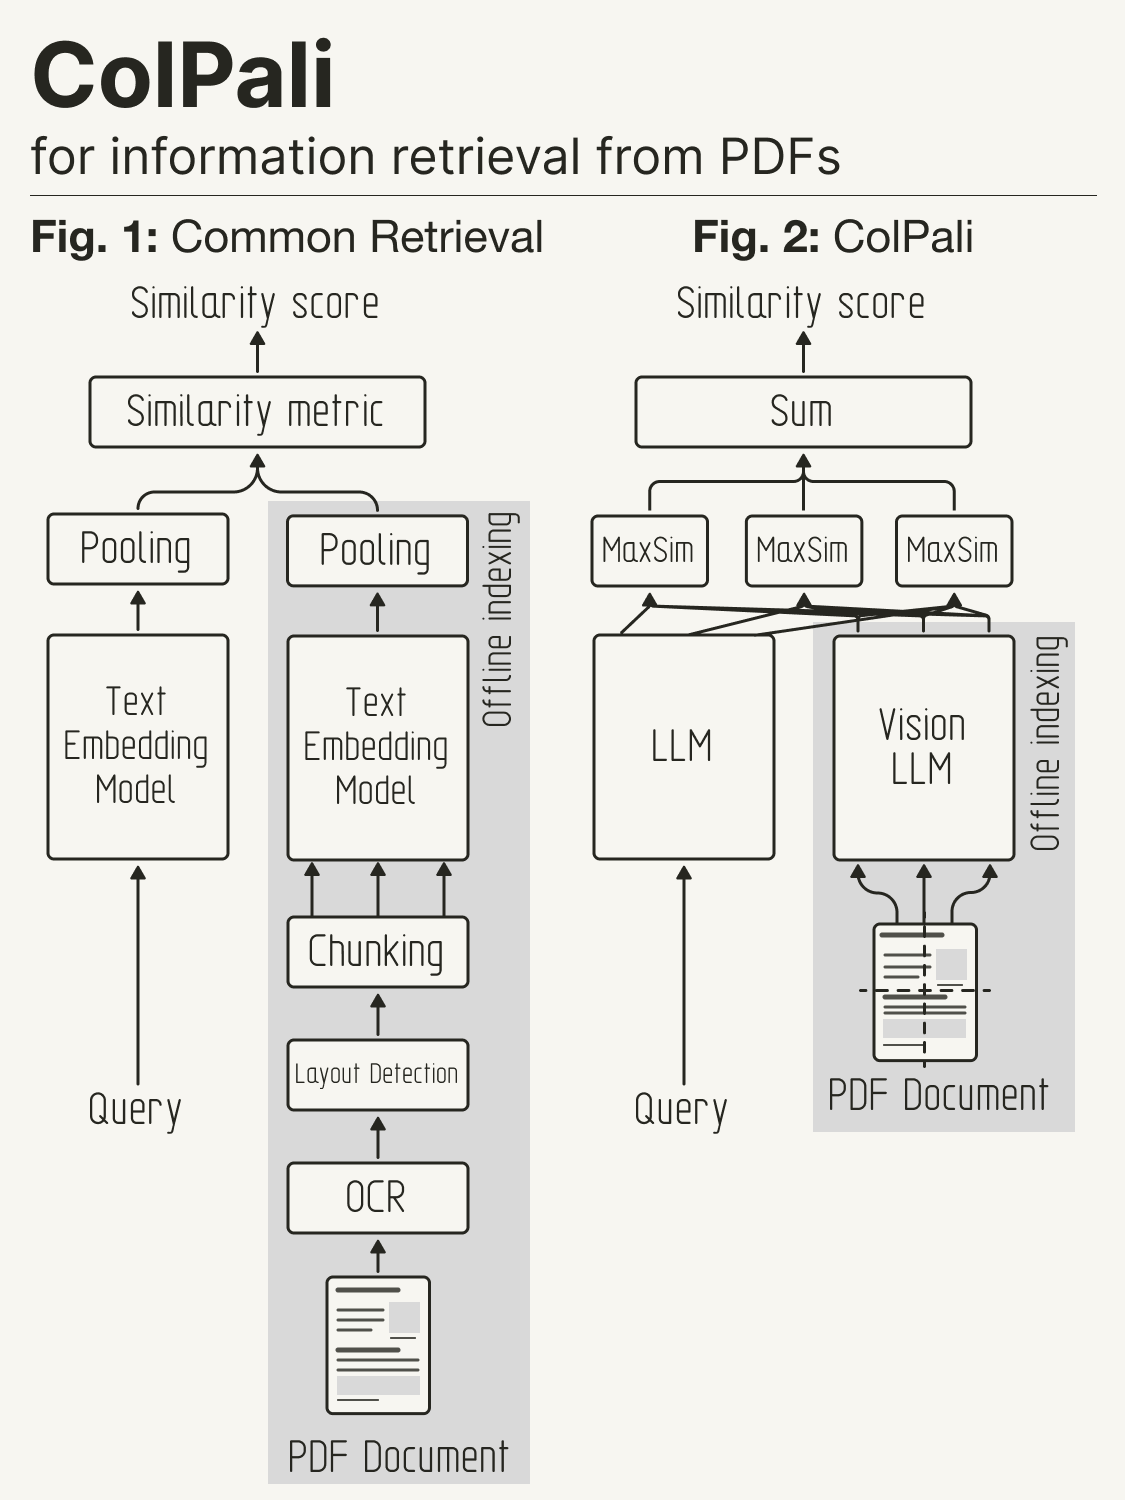

Let's play with ColPali and VLMs to do RAG without ever needing to extract text from images !

### Installation

In [ ]:
%%capture
!pip install transformers --upgrade
!pip install colpali-engine --upgrade
!apt-get install poppler-utils
!pip install pdf2image
!pip install openai
!pip install qwen_vl_utils

In [ ]:
from colpali_engine.models import ColQwen2, ColQwen2Processor
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

## ColPali Embeddings

### Model Loading

In [ ]:
import torch
from PIL import Image

from colpali_engine.models import ColQwen2, ColQwen2Processor


model = ColQwen2.from_pretrained(
        "vidore/colqwen2-v0.1",
        torch_dtype=torch.bfloat16, # switch to float16 if gpu does not support it
        device_map="cuda:0",  # or "mps" if on Apple Silicon
    )
processor = ColQwen2Processor.from_pretrained("vidore/colqwen2-v0.1")
model = model.eval()
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

ColQwen2(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Sequential(
        (0): L

### Document Conversion

In [ ]:
# upload a PDF - change this to put the document you cwant - doesn't need to be in English necessarily
!wget https://reseauactionclimat.org/wp-content/uploads/2018/04/powerpoint-final-kit.pdf -O test.pdf

--2024-10-21 09:34:07--  https://reseauactionclimat.org/wp-content/uploads/2018/04/powerpoint-final-kit.pdf
Resolving reseauactionclimat.org (reseauactionclimat.org)... 46.105.57.169
Connecting to reseauactionclimat.org (reseauactionclimat.org)|46.105.57.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14841042 (14M) [application/pdf]
Saving to: ‘test.pdf’

test.pdf            100%[===================>]  14.15M  8.89MB/s    in 1.6s    

2024-10-21 09:34:09 (8.89 MB/s) - ‘test.pdf’ saved [14841042/14841042]



In [ ]:
# convert all PDF pages to images
from pdf2image import convert_from_path
import base64
from io import BytesIO


images = convert_from_path('./test.pdf')

base64_images = []
for i in range(len(images)):
    buffered = BytesIO()
    images[i].save(buffered, format="JPEG")
    base64_images.append(base64.b64encode(buffered.getvalue()).decode('utf-8'))

In [ ]:
# Process the inputs by batches of 2 - modify it depending on your VRAM !
 # Run inference - docs
dataloader = DataLoader(
    dataset=images,
    batch_size=2,
    shuffle=False,
    collate_fn=lambda x: processor.process_images(x),
)

ds  = []
for batch_doc in tqdm(dataloader):
    with torch.no_grad():
        batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
        embeddings_doc = model(**batch_doc)
    ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))

100%|██████████| 29/29 [05:07<00:00, 10.61s/it]


### Inference

In [ ]:
def get_results(query: str):
    batch_queries = processor.process_queries([query]).to(model.device)

    # Forward pass
    with torch.no_grad():
        query_embeddings = model(**batch_queries)

    scores = processor.score_multi_vector(query_embeddings, ds)
    # get top-5 scores
    return scores[0].topk(5).indices.tolist()

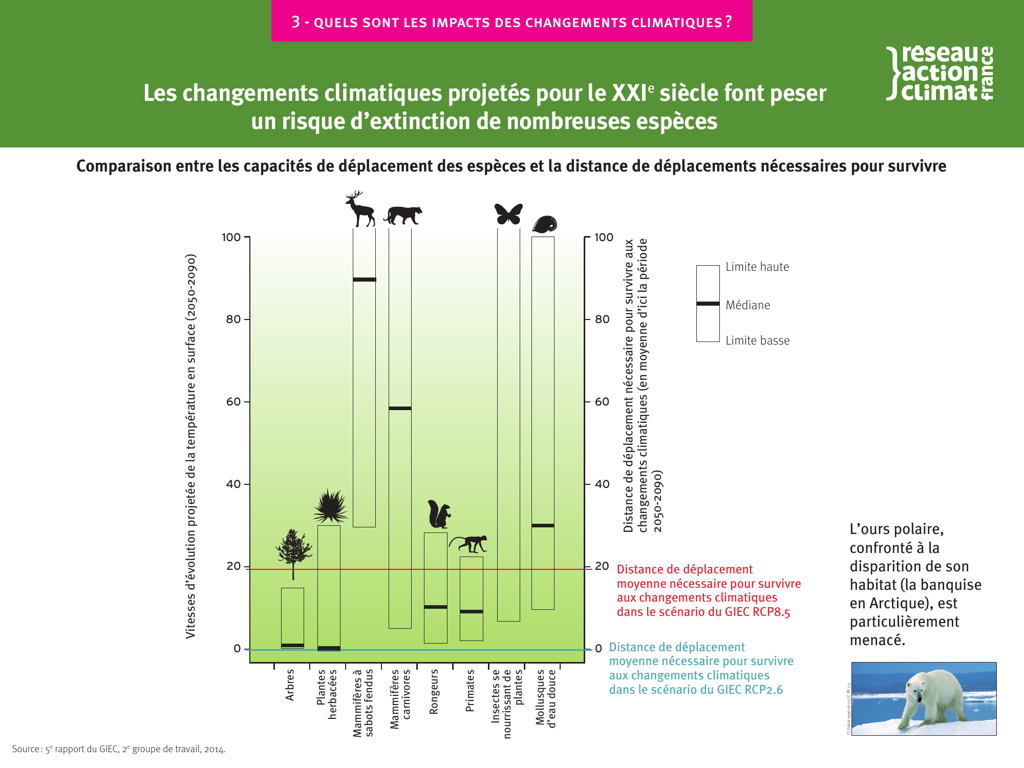

In [ ]:
# display and resize keepin aspect ratio
idx = get_results("What animals are in danger with climate change ?")[0]
im = images[idx]

def display_resize(im):
    shrink_factor = (im.size[0]/1024)
    display(im.resize((int(im.size[0]/shrink_factor), int(im.size[1]/shrink_factor))))

display_resize(im)

### Interpretability

What's cool is that we can see what part of the image were used to make the decision !

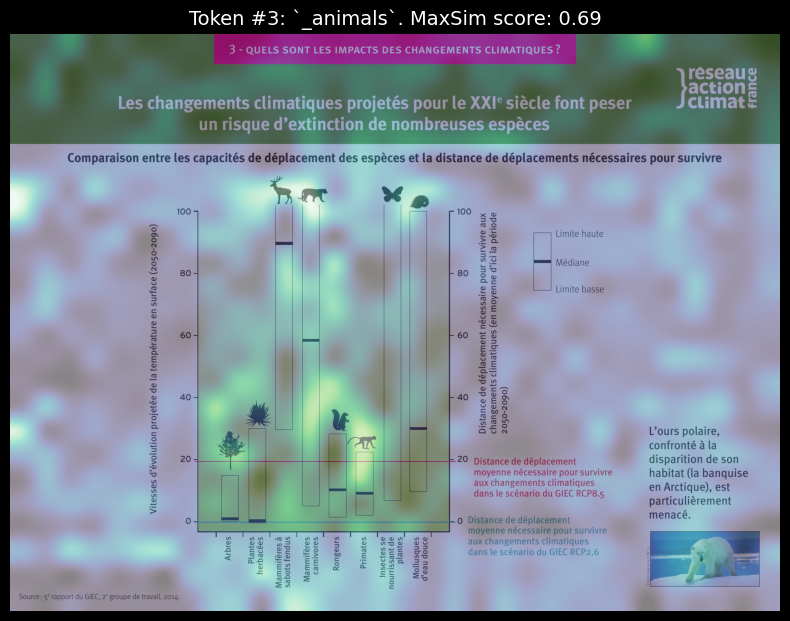

In [ ]:
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)


# Get the number of image patches
n_patches = processor.get_n_patches(
    image_size=im.size,
    patch_size=model.patch_size,
    spatial_merge_size=model.spatial_merge_size,
)


# Get the tensor mask to filter out the embeddings that are not related to the image
image_mask = processor.get_image_mask(processor.process_images([im]))

batch_queries = processor.process_queries(["What animals are in danger with climate change ?"]).to(model.device)
# Generate the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=ds[idx].unsqueeze(0).to("cuda"),
    query_embeddings=model(**batch_queries),
    n_patches=n_patches,
    image_mask=image_mask,
)

query_content = processor.decode(batch_queries.input_ids[0]).replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
query_tokens = processor.tokenizer.tokenize(query_content)

# Get the similarity map for our (only) input image
similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)


token_idx = 3 # for the third token

fig, ax = plot_similarity_map(
    image=im,
    similarity_map=similarity_maps[token_idx],
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx].replace('Ġ', '_')}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

del query_content, query_tokens, batch_queries, batched_similarity_maps, similarity_maps, image_mask, n_patches, im

## Generating a response

### Using Qwen2-VL

Let's first try this out with a small local model.
In practice, you would want to run this with a larger and better model !

In [ ]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch

# If you have more VRAM, feel free to use more powerful models !
gen_model = Qwen2VLForConditionalGeneration.from_pretrained("vidore/colqwen2-base",torch_dtype=torch.bfloat16).cuda().eval()

max_pixels = 512*28*28    # decrease resolution to fit in RAM at the cost of performance (if you have more RAM, feel free to up 512 to much higher)
gen_processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", max_pixels=max_pixels)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
PROMPT = """
Use the page to answer the query:
{query}
PDF pages:
"""

def get_answer_local(query: str):
    top_k = get_results(query)

    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": images[top_k[0]],
                },
                {"type": "text", "text": PROMPT.format(query=query)},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    image_inputs, video_inputs = process_vision_info(messages)
    inputs = gen_processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = gen_model.generate(**inputs, max_new_tokens=50)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = gen_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text, top_k

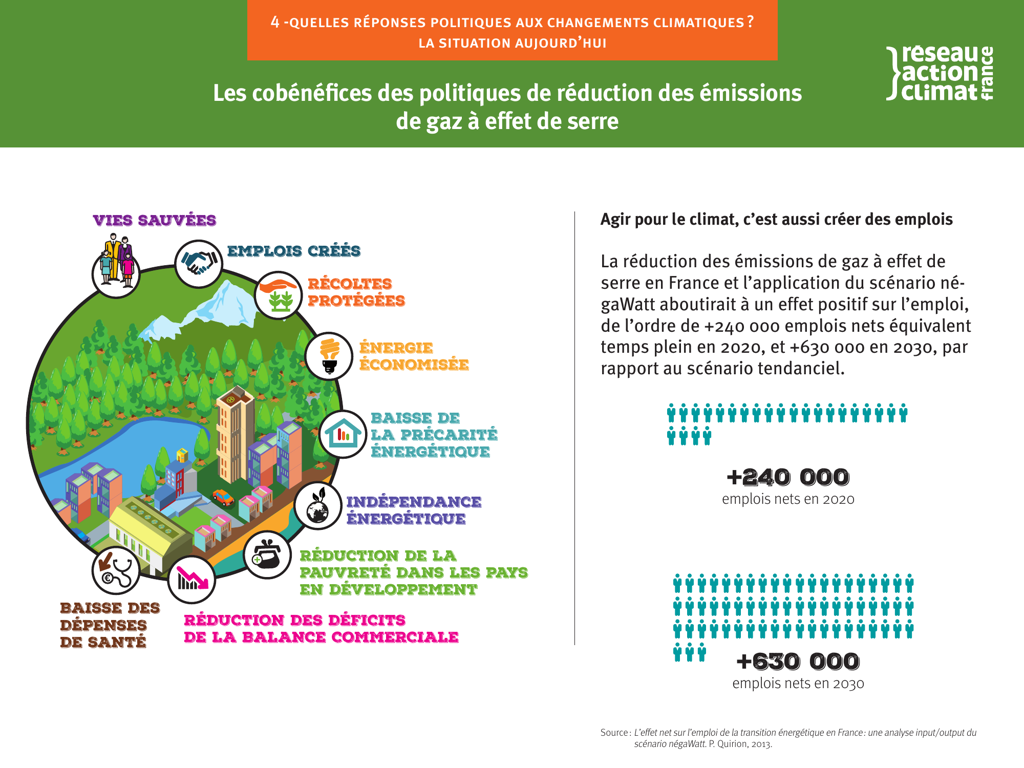

['According to the information provided, 240,000 jobs were created in the climate change sector in 2020.']


In [ ]:
# run retrieval
answer, top_k = get_answer_local("How many jobs were created in the climate change sector ?")

display_resize(images[top_k[0]])
print(answer)

### Using OpenAI

What if we had a very good VLM ? We would want to send multiple images to the model, can prompt it better and we get much more high quality results !

In [ ]:
from openai import OpenAI
import requests

# OpenAI API Key
api_key = "<your-api-key>"

client = OpenAI(api_key=api_key)

PROMPT = """
You are a smart assistant designed to answer questions about a PDF document.
You are given relevant information in the form of PDF pages. Use them to construct a response to the question, and cite your sources.
If it is not possible to answer using the provided pages, do not attempt to provide an answer and simply say the answer is not present within the documents.
Give detailed and extensive answers, only containing info in the pages you are given.
Answer in the same language as the query.

Query: {query}
PDF pages:
"""

def get_answer_openai(query: str):
    top_k = get_results(query)

    response = client.chat.completions.create(
      model="gpt-4o-mini",
      messages=[
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": PROMPT.format(query=query)
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[top_k[0]]}"
                },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[top_k[1]]}"
                },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[top_k[2]]}"
                },
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[top_k[3]]}"
                },
            },
          ],
        }
      ],
      max_tokens=500,
    )
    return response.choices[0].message.content, top_k

In [ ]:
# run retrieval
answer, top_k = get_answer("<your question>?")

display(images[top_k[0]])
print(answer)

## Your turn

Feel free to play with this by uploading other documents, asking various questions, changing the generative model, the prompt, the resolution...


Some ressources:
* Paper: https://arxiv.org/abs/2407.01449
* Github: https://github.com/illuin-tech/colpali


Notebook by [Manuel Faysse](https://manuelfay.github.io/).

Twitter: @ManuelFaysse